In [1]:
# Cell 1: Install necessary libraries if not already available
!pip install datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:0000:01


In [2]:
# Cell 2: Import libraries, configure warnings, and set up configurations

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Suppress specific warning from torch
import warnings
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0")

# Datasets for handling data, Evaluate for metrics
from datasets import Dataset, DatasetDict
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

In [3]:
# Cell 3: Data setup
DATA_PATH = "/kaggle/input/touche-task4-2025-subtask2/touche-task4-2025-subtask2"
train_responses_file = os.path.join(DATA_PATH, "responses-train.jsonl")
train_labels_file = os.path.join(DATA_PATH, "responses-train-labels.jsonl")
val_responses_file = os.path.join(DATA_PATH, "responses-validation.jsonl")
val_labels_file = os.path.join(DATA_PATH, "responses-validation-labels.jsonl")
test_responses_file = os.path.join(DATA_PATH, "responses-test.jsonl")
test_labels_file = os.path.join(DATA_PATH, "responses-test-labels.jsonl")

def load_jsonl(file_path):
    """Load a JSONL file and return a list of dicts."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

def merge_data(responses_file, labels_file):
    """Merge responses and labels using the response id."""
    responses = load_jsonl(responses_file)
    labels = load_jsonl(labels_file)
    label_map = {item["id"]: item["label"] for item in labels}
    
    merged = []
    for resp in responses:
        rid = resp["id"]
        if rid in label_map:
            merged.append({
                "id": rid,
                "text": resp["response"],
                "label": label_map[rid]
            })
    return merged

In [4]:
# Cell 4: Create Hugging Face Datasets for train/validation/test
train_data = merge_data(train_responses_file, train_labels_file)
val_data = merge_data(val_responses_file, val_labels_file)
test_data = merge_data(test_responses_file, test_labels_file)

train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 11487
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 2600
    })
})


In [5]:
# Cell 5: Tokenize using DeBERTa V3 Large tokenizer

model_checkpoint = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    # Using a maximum length of 512 tokens
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["id", "text"])

# Suppress the sentencepiece warning
import warnings
warnings.filterwarnings("ignore", message="The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option")


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/11487 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

In [6]:
# Cell 6: Create the model and data collator

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Cell 7: Define evaluation metrics and configure the Trainer

import evaluate

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Enable gradient checkpointing to reduce memory consumption during training
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,       # Further reduced batch size to lower memory usage
    per_device_eval_batch_size=8,        # Reduced evaluation batch size as well
    gradient_accumulation_steps=8,       # Accumulate gradients to simulate an effective batch size of 4
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True                          # Enable mixed precision training for memory efficiency
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-2705a3e00b11>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
# Cell 8: Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.045200,0.054300,0.991710,0.999136,0.978003,0.988457
2,0.016700,0.025997,0.995702,0.996599,0.991540,0.994063
3,0.010500,0.020265,0.995702,0.997445,0.990694,0.994058
4,0.000000,0.033806,0.995000,0.996689,0.989047,0.992853


SafetensorError: Error while serializing: IoError(Os { code: 28, kind: StorageFull, message: "No space left on device" })

In [9]:
# Cell 9: Evaluate on the test set
test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("Test set metrics:", test_metrics)

Test set metrics: {'eval_loss': 0.033806201070547104, 'eval_accuracy': 0.995, 'eval_precision': 0.9966887417218543, 'eval_recall': 0.9890470974808324, 'eval_f1': 0.9928532160527763}


In [11]:
# Cell 10: Save the fine-tuned model and tokenizer
model_save_path = "./deberta-v3-large-ad-detector-finetuned"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

OSError: [Errno 28] No space left on device: './deberta-v3-large-ad-detector-finetuned'

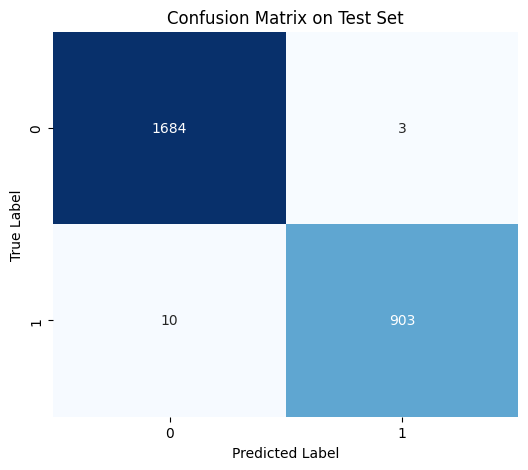

In [12]:
# Cell 11: Compute and plot the confusion matrix for the test set
test_output = trainer.predict(tokenized_datasets["test"])
predictions = test_output.predictions.argmax(axis=-1)
true_labels = test_output.label_ids

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

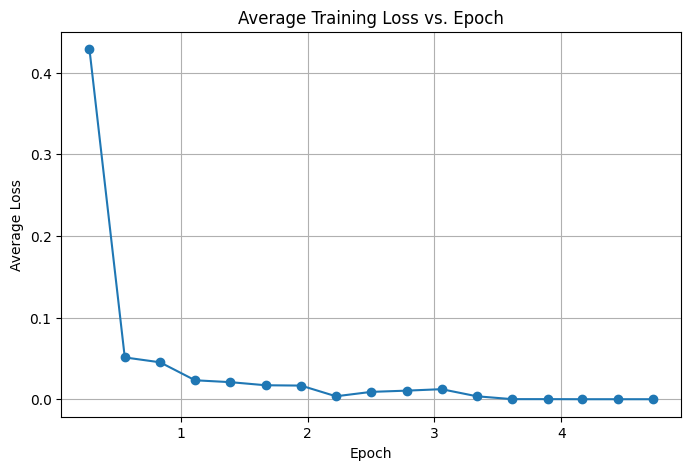

In [15]:
# Cell 12: Extract training loss logs and plot average loss per epoch
log_history = trainer.state.log_history
epoch_loss = {}
for entry in log_history:
    if "epoch" in entry and "loss" in entry:
        epoch = entry["epoch"]
        if epoch not in epoch_loss:
            epoch_loss[epoch] = []
        epoch_loss[epoch].append(entry["loss"])

epoch_loss_avg = {epoch: sum(losses) / len(losses) for epoch, losses in epoch_loss.items()}
sorted_epochs = sorted(epoch_loss_avg.keys())
sorted_loss = [epoch_loss_avg[epoch] for epoch in sorted_epochs]

plt.figure(figsize=(8,5))
plt.plot(sorted_epochs, sorted_loss, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Training Loss vs. Epoch")
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


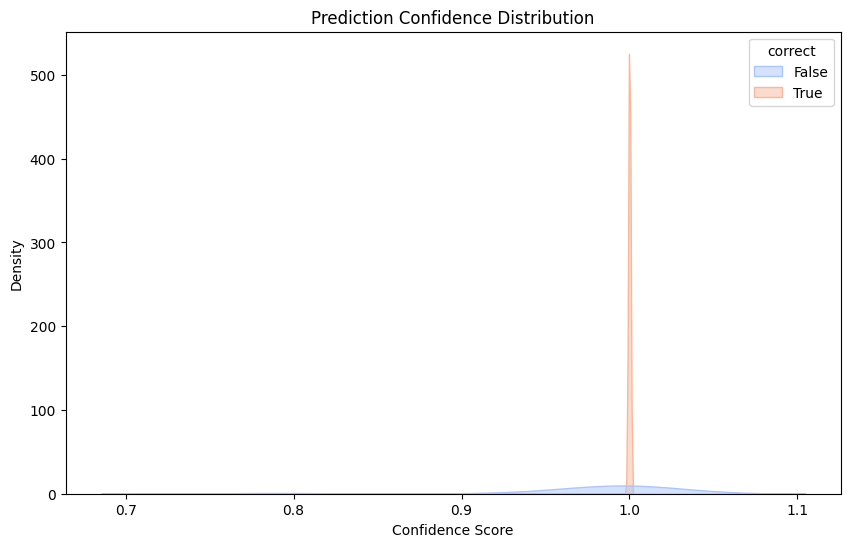

<ipython-input-20-16c4f877c8c7>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_rate_by_length = error_df.groupby('text_length_bin')['correct'].mean().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


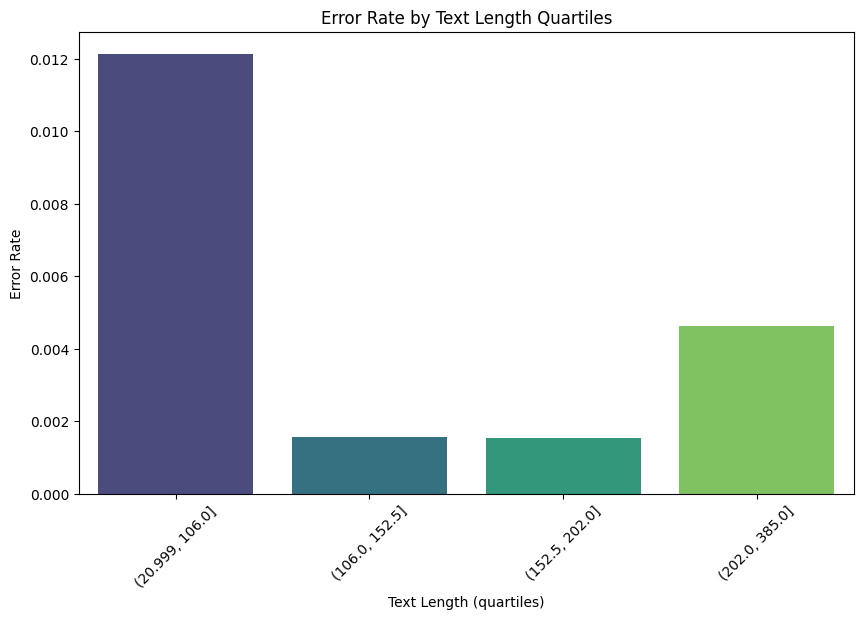

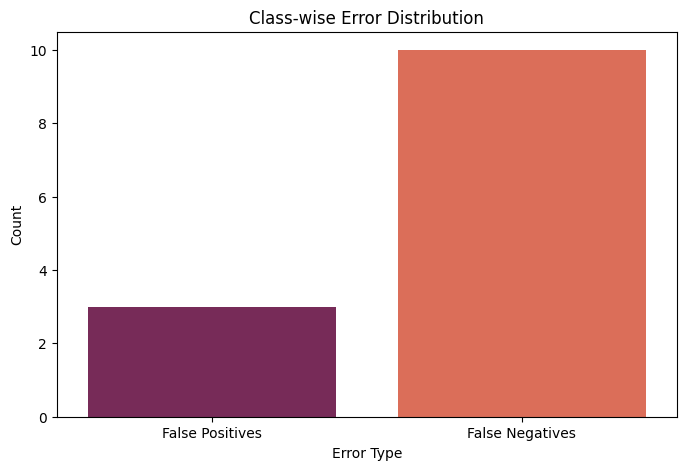


Most Confident Errors:


,text,label,predicted,probability
1109,"About RPR (Realtors Property Resource)\nRPR, or Realtors Property Resource, is a comprehensive property database and platform designed exclusively for REALTORS. With the addition of the mobile extension RPR Mobile, real estate professionals can now deliver on-the-go reports and serve their clients with the same level of accuracy wherever they may be. It provides access to a wide range of data, tools, and reports to assist real estate professionals in their transactions and client interactions. RPR is managed by the National Association of Realtors (NAR) and is available only to association members, including commercial and residential real estate brokers, agents, and other real estate industry professionals.\nKey Features and Benefits\nComprehensive Data: RPR offers comprehensive data, powerful analytics, and dynamic reports for each of NAR's members.\nExclusive Access: It is only available to REALTORS and does not have third-party or public access. Additionally, it is included in ...",1,0,0.999983
2550,"Sami Clarke is a Colombian professional fitness model, celebrity personal trainer, and internet star. She was born in 199. She is known for her fitness perfect and passion for modeling. She is also involved in training celebrities personally and has now become an internet star. She is the founder of FORM, a holistic and community-driven approach to wellness, where the commitment to oneself unlocks the ultimate version of self-care.\nIs there anything else I can help you with?",0,1,0.999968
1592,"Peacock TV is a streaming service owned by NBCUniversal that offers a diverse catalog of TV shows, movies, news, sports, and original content, including the entire series of the critically acclaimed show ""The Office"", now available to stream exclusively on Peacock. Peacock offers a free tier with ads and premium plans, Peacock Premium and Peacock Premium Plus, providing broader access to content with and without ads, respectively. Plans start at $.99/month and you can stream on 3 devices at once.\nI hope this helps!",1,0,0.999864
29,"You can access Bank of America’s online banking service by logging in with your user ID and password on their website. You can manage your personal and small business accounts, view balances, transfer funds, pay bills, and more through their comprehensive digital banking ecosystem. Bank of America also offers various credit cards with different rewards and benefits, as well as financial guidance and other services.\nIs there anything else I can help you with?",1,0,0.999727
47,"Bank of America offers online banking services that allow customers to manage their accounts, make transactions, and access a spectrum of financial solutions from the comfort of their own home or on the move. The Bank of America Mobile Banking app provides additional convenience and features for customers on the go. Some of the features of the Mobile Banking app include customizable alerts, check deposit through photo, and quick access using fingerprint or Face ID.\nTo access Bank of America's online banking services, customers can log in using their User ID and password on the Bank of America website The website provides a secure platform for customers to view their account information, make transfers, pay bills, and perform other banking activities.\nBank of America also has a network of financial centers and ATMs across the United States. Customers can use the Bank of America website to locate the nearest financial center or ATM.\nFor security purposes, Bank of America may requi...",1,0,0.999692
51,"About Citibank Online\nCitibank Online is a digital banking platform offered by Citibank, providing customers with convenient access to a wide range of banking services and features, allowing for seamless management of global finances from virtually anywhere in the world. While the platform offers various services, it's important to note that there may be occasional downtimes for maintenance or


Least Confident Correct Predictions:


,text,label,predicted,probability
1660,"To watch Fox live stream for free, you have a few options:\nFOX NOW: Unveil a world of entertainment where you can enjoy live and on-demand streaming of hit FOX shows anytime, anywhere with the FOX NOW app. The app also allows you to watch sports games and the latest news. The app is available for download on the App Store and Google Play Store.\nFOX Sports: If you're interested in watching live sports events on FOX, you can use the FOX Sports app. The app allows you to stream live and on-demand games from FOX, FS1, FS2, and FOX Deportes. It covers a wide range of sports, including NFL, college football, MLB, NASCAR, and more. The app is available for download on the App Store and Google Play Store.\nPlease note that some content on these platforms may require a cable TV subscription or a TV provider sign-in. Additionally, availability may vary depending on your location.\nI hope this helps! Let me know if you have any other questions.",1,1,0.846990
1116,"Professional Property Management Services\nProfessional property management companies offer a range of services to rental owners and tenants. These services include property maintenance, tenant screening, rent collection, lease enforcement, and financial reporting. Here are some snippets from various property management companies:\nMissoula and Ravalli counties\n: ""Our company offers effective property management services to rental owners throughout Missoula and Ravalli counties, incorporating secure and efficient self-guided touring technology that enhances our offerings.""\nRaleigh, Durham & other North Carolina areas\n: ""Professional Properties Management (PPM) has been delivering the highest quality property management services since 1985"".\nBay Area\n: ""Professional Property Management is a Leader of Residential and Commercial Property Management Solutions in the Area with locations strategically located"".\nInland Empire\n: ""We are one of the leading property management compani...",1,1,0.930395
2409,"You are looking for Disneyland vacation packages. You can visit the official Disneyland Resort website to learn more about the available packages that fit your budget and needs. The website also provides information on places to stay, things to do, and the Magic Key shop. You can also plan a family vacation to the Disneyland Resort and enjoy all the happiness of classic Disneyland Park and Disney California Adventure Park, which includes the revved-up and “tire”-ific Cars Land and the Downtown Disney District. If you are looking for discounted Disneyland family vacations and affordable family travel to San Diego, Universal Studios, and more, you can check out Get Away Today. They offer up to 50% discount on your next family vacation. Have fun planning your trip! 🎉",0,0,0.996176
2413,"If you’re looking for an all-expense-paid trip, you might want to consider all-inclusive vacation packages. These packages cover everything from your room to your cocktail choice in a single price, allowing you to indulge in a bounty of local and international foods, try new activities, and put away your purse on the ultimate stress-free vacation.\nExpedia offers a wide range of all-inclusive vacation packages that can be customized to your preferences. You can choose from a variety of destinations such as Hawaii, Mexico, and Cancun, and enjoy a range of activities such as swimming, surfing, snorkeling, and more.\nPlease note that the availability of all-inclusive vacation packages may vary depending on the destination and time of year. It’s always a good idea to check with the travel provider for the latest information.\nEnjoy your trip! 🌴🍹",0,0,0.996441
973,"First Health Network Insurance is a type of health insurance that offers its members a wide range of healthcare benefits. It serves as a network that connects you with healthcare providers, facilitating access to medical services. First Health Network Insurance offers a range of health insuranc

In [ ]:
# Cell 12a: Enhanced Error Analysis
import torch  # Added import
import pandas as pd

# First get prediction probabilities from test output
probabilities = torch.nn.functional.softmax(torch.tensor(test_output.predictions), dim=1).numpy()
test_data_with_preds = test_data.copy()

# Add prediction info (existing code)
for i in range(len(test_data_with_preds)):
    test_data_with_preds[i]['predicted'] = predictions[i]
    test_data_with_preds[i]['probability'] = float(probabilities[i][predictions[i]])
    test_data_with_preds[i]['correct'] = (predictions[i] == test_data_with_preds[i]['label'])
    test_data_with_preds[i]['text_length'] = len(test_data_with_preds[i]['text'].split())
# Convert to DataFrame for easier analysis
error_df = pd.DataFrame(test_data_with_preds)

# 1. Confidence Distribution Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=error_df, x="probability", hue="correct",
    fill=True, common_norm=False, palette="coolwarm", alpha=.5
)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence Score")
plt.show()

# 2. Error Rate by Text Length
error_df['text_length_bin'] = pd.qcut(error_df['text_length'], q=4)
error_rate_by_length = error_df.groupby('text_length_bin')['correct'].mean().reset_index()
error_rate_by_length['error_rate'] = 1 - error_rate_by_length['correct']

plt.figure(figsize=(10, 6))
sns.barplot(x='text_length_bin', y='error_rate', data=error_rate_by_length, palette="viridis")
plt.title("Error Rate by Text Length Quartiles")
plt.xlabel("Text Length (quartiles)")
plt.ylabel("Error Rate")
plt.xticks(rotation=45)
plt.show()



error_types = pd.DataFrame({
    'Error Type': ['False Positives', 'False Negatives'],
    'Count': [fp, fn]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Error Type', y='Count', data=error_types, palette="rocket")
plt.title("Class-wise Error Distribution")
plt.show()

# 4. Top Misclassified Examples
pd.set_option('display.max_colwidth', 1000)
print("\nMost Confident Errors:")
display(error_df[error_df['correct'] == False].sort_values('probability', ascending=False)[['text', 'label', 'predicted', 'probability']].head(20))

print("\nLeast Confident Correct Predictions:")
display(error_df[error_df['correct'] == True].sort_values('probability')[['text', 'label', 'predicted', 'probability']].head(20))

✅ Model loaded on cuda


Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 2600/2600 [02:14<00:00, 19.36it/s]


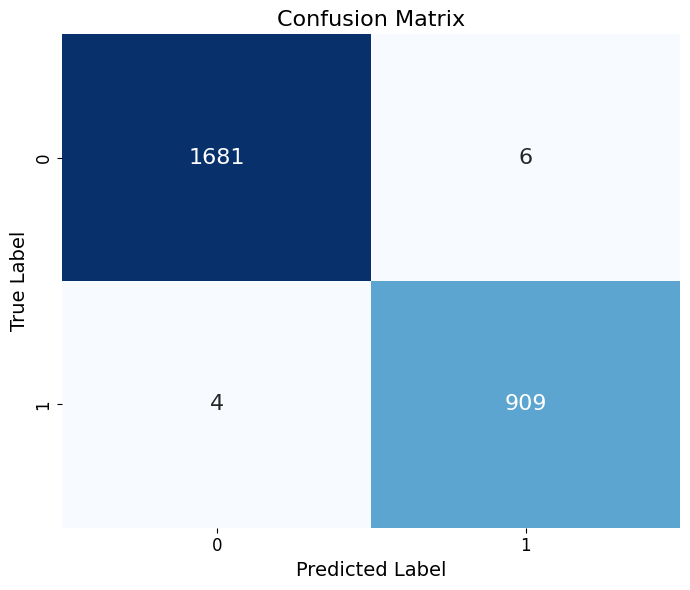

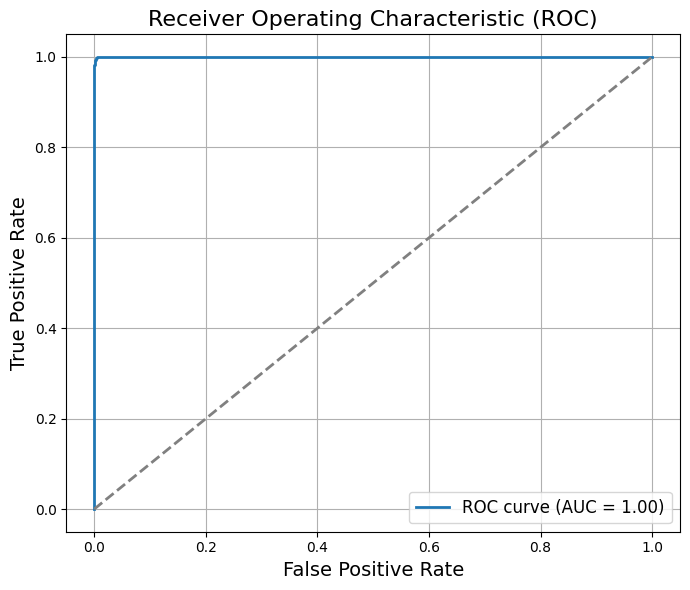

In [8]:
# Cell: Load model and tokenizer from Hugging Face Hub
import os, json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Load model and tokenizer
model_id = "Sameer121/deberta-v3-large-ad-detector-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Model loaded on", device)

# Load test data
def load_jsonl(fp):
    data = []
    with open(fp, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def merge_data(resp_fp, lbl_fp):
    resp = load_jsonl(resp_fp)
    lbls = load_jsonl(lbl_fp)
    lm = {x["id"]: x["label"] for x in lbls}
    out = []
    for r in resp:
        if r["id"] in lm:
            out.append({"text": r["response"], "label": lm[r["id"]]})
    return out

DATA_PATH = "/kaggle/input/touche-task4-2025-subtask2/touche-task4-2025-subtask2"
test_data = merge_data(
    os.path.join(DATA_PATH, "responses-test.jsonl"),
    os.path.join(DATA_PATH, "responses-test-labels.jsonl")
)
test_dataset = Dataset.from_list(test_data)

# Tokenize (keep labels)
def tokenize_and_keep_labels(example):
    tok = tokenizer(example["text"], truncation=True, max_length=512)
    tok["label"] = example["label"]
    return tok

tokenized_test = test_dataset.map(
    tokenize_and_keep_labels,
    batched=False,
    remove_columns=["text"]
)

# Inference loop (per example)
model.eval()
all_logits = []
all_labels = []

for ex in tqdm(tokenized_test, desc="Evaluating"):
    input_ids = torch.tensor([ex["input_ids"]], device=device)
    attention_mask = torch.tensor([ex["attention_mask"]], device=device)
    label = ex["label"]
    with torch.no_grad():
        out = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = out.logits.squeeze(0).cpu().numpy()
    all_logits.append(logits)
    all_labels.append(label)

# Stack & compute
logits      = np.vstack(all_logits)
true_labels = np.array(all_labels)
probs       = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
preds       = logits.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], lw=2, linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


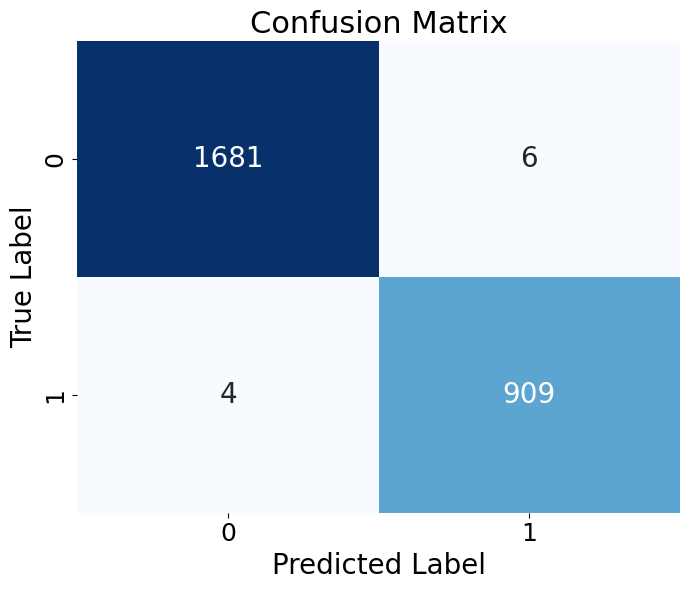

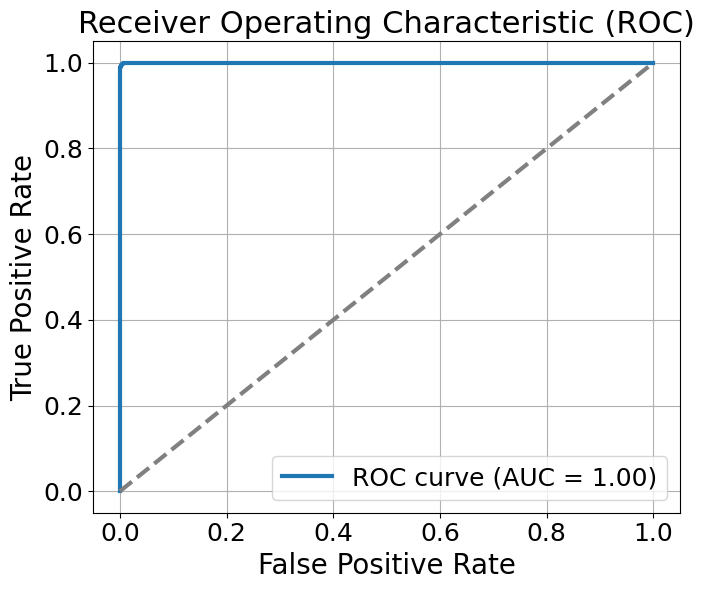

In [9]:
# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(7, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 20}           # annotation font size
)

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("Confusion Matrix", fontsize=22)

# x- and y-tick label sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()


# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=3, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], lw=3, linestyle="--", color="gray")

plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.title("Receiver Operating Characteristic (ROC)", fontsize=22)

# make the legend and tick labels bigger
plt.legend(loc="lower right", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True)
plt.tight_layout()
plt.show()
